In [1]:
import sys
import os
import pandas as pd
import numpy as np
import random
import scipy
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import networkx as nx
from scipy import sparse
import hypernetx as hnx
import time

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

In [2]:
def load_pathway(fpath):
    """
    Loads an Enrichr-like database file into a boolean DataFrame.

    Args:
        fpath (str): Path to the Enrichr-like database file.

    Returns:
        pandas.DataFrame: A boolean DataFrame where:
            - Index: Genes
            - Columns: Pathways
            - Values: True if the gene is in the pathway, False otherwise.
    """

    result = []
    with open(fpath,  encoding='utf-8') as f:
        for line in f:
            split_line = [x for x in line.strip().split('\t') if x]  # Remove empty strings directly

            row = {'label': split_line[0]}
            for gene in split_line[1:]:
                row[gene] = 1

            result.append(row)

    df = pd.DataFrame(result)
    df = df.fillna(0.0).set_index('label').astype(bool).T  # Chained operations for clarity

    return df

fpath = "../../ONT-single-cell/resources/PanglaoDB_Augmented_2021.txt"
pdf = load_pathway(fpath)
stem_genes = list(pdf[pdf['Embryonic Stem Cells']].index)
stem_genes = [x.title() for x in stem_genes]
stem_genes[:10]

['Gjb1',
 'Amotl2',
 'Yap1',
 'Fbln1',
 'Uaca',
 'Antxr1',
 'Fermt2',
 'Serpinh1',
 'Pls3',
 'Gpx8']

In [3]:
# load the hypergraph:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/core_of_core/sparse_hypergraph.pkl"
H = pd.read_pickle(fpath)
print(f"{H.shape=}")
H.head()

H.shape=(24415, 35343)


,66953ddf-e76d-4cdf-aaf8-be028a2d7b04,c160a170-5af7-412b-9c03-36dfef017384,a8241f5d-1189-49c9-a948-c6a1c91cdf17,3b0686b6-f18f-495d-89f5-8c8b286c2bb1,77bc1796-a0a3-4140-a97b-d4a786d17cb2,4f913e8a-799a-488e-a7bd-6ae9566e5c37,a425bdc9-37ea-4020-bc7c-5085fb99a3c7,8ad994fd-c214-46f9-99b0-37c2b3f2946e,b11c9d23-365a-44f5-ace6-217680ce31e8,c0af4b45-8929-41d6-982f-8a5ba6051d41,...,6e74d129-3498-42b0-ade9-0d35f60543af,eae8359f-2057-4492-93d1-10437e892f0b,01f1812f-b821-493c-bc17-3e5e6d453f2c,fcf0a060-2833-4ff0-a352-d5e702f27f46,6199d009-7ef7-44f6-b10c-c0ac846f362c,06857eb1-74b5-484c-9eb3-b0ced3498887,689b7cde-4f15-4869-bda9-bb49cf4e5676,9f9a0a4e-630b-406a-bb24-7026948c9787,acfb51fd-375f-42ac-839c-326616ea1953,de0a50ba-dade-46ba-9ed2-583b92b669b2
Smarca2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sh2d5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ppp1r15b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dyrk1a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Igf2bp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# load the edge centralities
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/core_of_core/edge_centralities.parquet"
edges = pd.read_parquet(fpath)
print(f"{edges.shape}")

edges.head()

(35343, 4)


,read_name,score,norm_score,order
0,447e44a1-c2bb-4604-acdd-48ee4d5a8569,0.000377,1.000000,3
1,d16238ba-3f72-4d62-a57a-f57ac2852da9,0.000361,0.957175,3
2,f32fce98-d99e-4341-ade9-bab53af61864,0.000355,0.941541,3
3,4accbf99-112a-4454-8eab-2861658368fb,0.000347,0.920801,3
4,a320d93f-1307-411a-93cb-76a62b6d6b88,0.000338,0.896880,3


In [5]:
# load the node centralities
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/core_of_core/node_centralities.parquet"
nodes = pd.read_parquet(fpath)
print(f"{nodes.shape}")

""" LOAD the genes """
fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/lightweight/population_mESC_{1000000}_gdf.parquet"
genes = pd.read_parquet(fpath, columns=['gene_name', 'gene_biotype'])
genes = genes.drop_duplicates()
print(f"{genes.shape=}")

nodes = pd.merge(
    nodes, genes, how='left'
)

tf_list = nodes[nodes['is_tf']]['gene_name'].to_list()
pt_list = nodes[nodes['gene_biotype'] == 'protein_coding']['gene_name'].to_list()
print(f"{len(tf_list)=}")
print(f"{len(pt_list)=}")

nodes.head()

(24415, 5)
genes.shape=(47398, 2)
len(tf_list)=1654
len(pt_list)=17217


,gene_name,expression,is_tf,score,norm_score,gene_biotype
0,Zfp111,5.62,True,0.000175,1.000000,protein_coding
1,Gm7803,0.30,False,0.000166,0.952722,processed_pseudogene
2,Sfxn5,1.18,False,0.000165,0.942303,protein_coding
3,Gm35769,0.00,False,0.000164,0.941602,lncRNA
4,Gm26650,0.00,False,0.000163,0.934134,lncRNA


# Plot the most central

(raw) hypergraph.shape=(24415, 35343)
(filtered) hypergraph.shape=(17217, 15)


/home/cstansbu/miniconda3/envs/higher_order/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


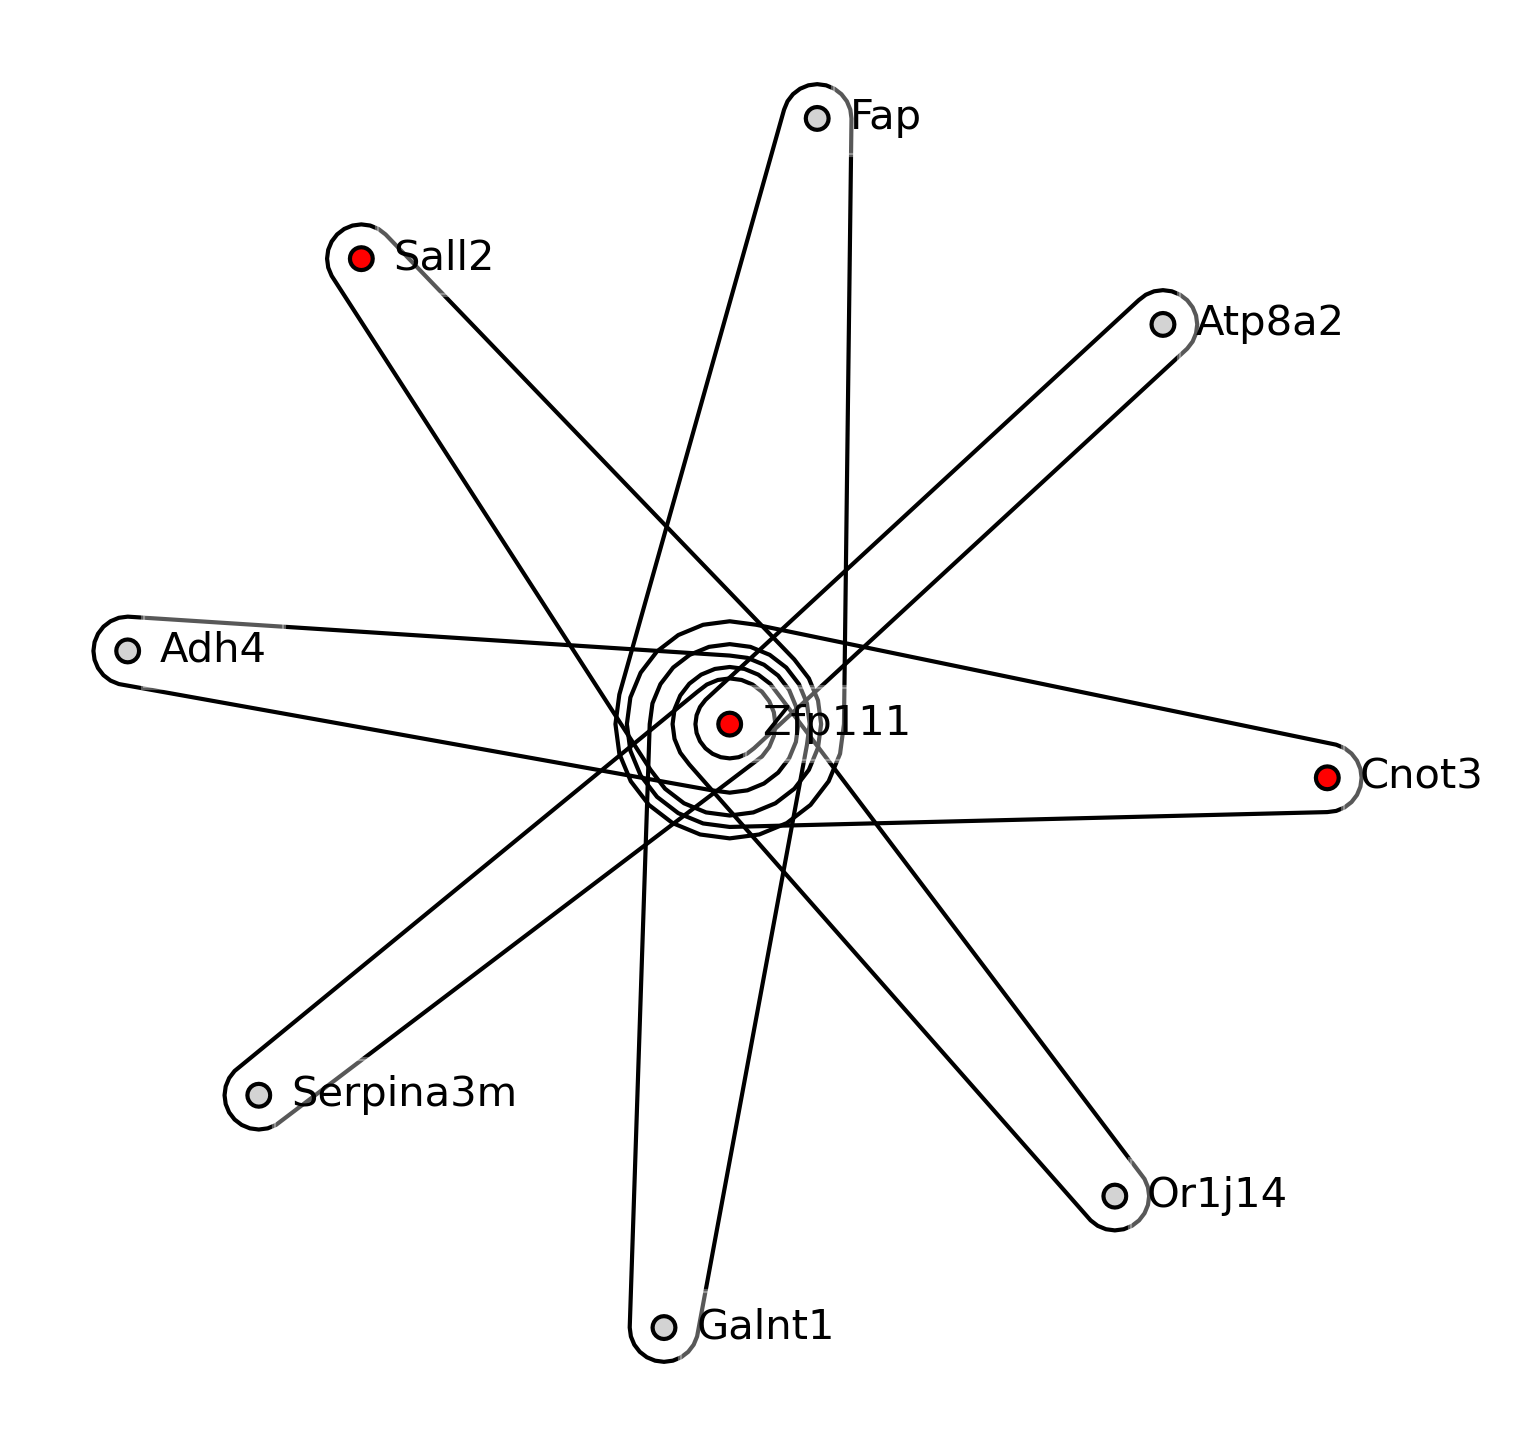

In [6]:
def to_hypernet(H, order=None, strict=False):
    """A function to convert a dataframe into a 
    hypernet hypergraph"""
    iteractions = {}
    for read_name, row in H.T.iterrows():
        
        hyperedge = tuple(row[row > 0].index)
        if not order is None:
            if strict:
                if not len(hyperedge) == order:
                    continue
            else:
                if not len(hyperedge) >= order:
                    continue            
        
        iteractions[read_name] = hyperedge
    hx = hnx.Hypergraph(iteractions)
    return hx

hypergraph = H.copy()
print(f"(raw) {hypergraph.shape=}")
hypergraph = hypergraph[hypergraph.index.isin(pt_list)]
hypergraph = hypergraph[edges['read_name'].head(15)]
print(f"(filtered) {hypergraph.shape=}")
hx = to_hypernet(hypergraph, order=2)

colors = {x: 'r' if x in tf_list else 'lightgrey' for x in hypergraph.index}

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6

plt.figure(facecolor='none') 

hnx.drawing.draw(
    hx, 
    with_node_counts=False, 
    with_node_labels=True, 
    with_edge_counts=False,
    with_edge_labels=False, 
    node_radius=0.75,
    nodes_kwargs={'color' : colors, 'edgecolor' : 'k',},
    layout_kwargs = {'seed': 39},
    edges_kwargs={'edgecolors' : 'k', 'linewidth' : 1,},
)

# mESC hubs

In [7]:
def remove_disconnected_components(graph):
  """
  Removes all but the largest connected component from a graph.

  Args:
    graph: The input graph.

  Returns:
    A new graph containing only the largest connected component.
  """
  connected_components = list(nx.connected_components(graph))
  largest_component = max(connected_components, key=len)
  return graph.subgraph(largest_component)

def alternating_walk_top_nodes(graph, start_node):
  """
  Performs an alternating walk on a bipartite graph and returns 
  only the top nodes in the walk.

  Args:
    graph: The bipartite graph.
    start_node: The node to start the walk from.

  Returns:
    A list of top nodes in the alternating walk.
  """
  top_nodes = []
  current_set = graph.nodes[start_node]['bipartite'] 
  if current_set == 0:  # Assuming 0 represents the top set
    top_nodes.append(start_node)

  for node in nx.bfs_tree(graph, source=start_node):
    if graph.nodes[node]['bipartite'] != current_set:
      if graph.nodes[node]['bipartite'] == 0:  # Check if the node is in the top set
        top_nodes.append(node)
      current_set = graph.nodes[node]['bipartite']
  return top_nodes

In [9]:
query_H = H.copy()

# get mESC marker genes
query_H = query_H[query_H.index.isin(stem_genes)]

# identify reads containing a stem marker
reads = query_H.columns[query_H.sum(axis=0) >= 1]
print(f"{len(reads)} hyperedges with stem cell markers")

# this is ugly - rewriting the object to extract
# all reads with stem markers
query_H = H[reads].copy()

""" GET LARGEST CONNECTED COMPONENT and walk """
hx = to_hypernet(query_H)
G = hx.bipartite()
G = remove_disconnected_components(G) 
top_nodes, bottom_nodes = nx.bipartite.sets(G)
start_node = nodes[nodes['gene_name'].isin(bottom_nodes)]['gene_name'].values[0] # start from the nth most central node!
print(f"starting from {start_node}")
walk = alternating_walk_top_nodes(G, start_node)
print(f"walk length {len(walk)}")

# establish the sort order based on edge centrality
query_edges = edges[(edges['read_name'].isin(walk))]
score_dict = dict(zip(query_edges['read_name'].values, query_edges['norm_score'].values))
query_H = query_H.reindex(columns=query_edges['read_name'].values)
print(f"(genes x hyperedges) {query_H.shape=}")
query_H.head()

634 hyperedges with stem cell markers
starting from Zfp111
walk length 6
(genes x hyperedges) query_H.shape=(24415, 6)


,0ac89205-1b09-405a-81d8-dd857b8df297,5ddc0f53-6b95-408f-84c8-273fb14e4bfe,68adaf9b-001c-46e9-95db-7cda9be72e9c,d96422fb-22d6-4b54-b41e-c8e5f88a4a75,e2290d29-c7dc-4930-85d8-7b85fa872168,88325698-85d9-4497-80a6-a6cae77e461f
Smarca2,0,0,0,0,0,0
Sh2d5,0,0,0,0,0,0
Ppp1r15b,0,0,0,0,0,0
Dyrk1a,0,0,0,0,0,0
Igf2bp3,0,0,0,0,0,0


In [ ]:
""" PLOT the hypergraph """
hx = to_hypernet(query_H)

colors = {x: 'r' if x in tf_list else 'lightgrey' for x in query_H.index}
labels = {x: x if x in tf_list else '' for x in query_H.index}

cmap_name = 'viridis'
cmap = plt.get_cmap(cmap_name) 

def edge_color(edge):
    return cmap(score_dict[edge])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6

plt.figure(facecolor='none') 
hnx.drawing.draw(
    hx, 
    with_node_counts=False, 
    with_node_labels=True, 
    with_edge_counts=False,
    with_edge_labels=False, 
    node_labels=labels,
    node_radius=0.75,
    nodes_kwargs={'color' : colors, 'edgecolor' : 'k',},
    node_labels_kwargs={'fontsize' : 6, 'color' : 'r'},
    layout_kwargs = {'seed': 39},
    edges_kwargs={
            'edgecolors': 'k', 
            'linewidths' : 0.5, 3
            'facecolors': edge_color, 
            'alpha' : 0.25,
    },
)

In [ ]:
break

# a general walk

In [ ]:
nth_most_central = 0

hx = to_hypernet(H)
G = hx.bipartite()
G = remove_disconnected_components(G) 
top_nodes, bottom_nodes = nx.bipartite.sets(G)
start_node = nodes[nodes['gene_name'].isin(bottom_nodes)]['gene_name'].values[nth_most_central] # start from the nth most central node!
print(f"starting from {start_node}")
walk = alternating_walk_top_nodes(G, start_node)
print(f"walk length {len(walk)}")

# establish the sort order based on edge centrality
query_edges = edges[(edges['order'] >= order) & (edges['read_name'].isin(walk))]
score_dict = dict(zip(query_edges['read_name'].values, query_edges['norm_score'].values))
query_H = query_H.reindex(columns=query_edges['read_name'].values)
print(f"(genes x hyperedges) {query_H.shape=}")
query_H.head()

In [ ]:
break

# Better selection

In [ ]:
order = 3
retain = 25
per_gene_limit = 2
pt_set = set(pt_list)

results = []
gene_counts = {}

count = 0

# establish the sort order
query_edges = edges[edges['order'] >= order]
score_dict = dict(zip(query_edges['read_name'].values, query_edges['norm_score'].values))
query_H = H.reindex(columns=query_edges['read_name'].values)
print(f"(genes x hyperedges) {query_H.shape=}")

start_time = time.time()  # Start overall timer

for attempts, read_name in enumerate(query_H.columns):
    if count == retain:
        break

    hyperedge = query_H[read_name][query_H[read_name] > 0].index
    hyperedge = hyperedge.intersection(pt_set)

    success = True

    if not len(hyperedge) >= order:
        success = False

    gene_count_start_time = time.time() 
    for gene in hyperedge:
        if not gene in gene_counts:
            gene_counts[gene] = 1
        elif gene_counts[gene] < per_gene_limit:
            gene_counts[gene] = gene_counts[gene] + 1
        else:
            success = False
    gene_count_end_time = time.time()

    if success:
        count += 1
        print(f"{count} of {retain} ({attempts} total attempts)")

        results.append({
            'read_name': read_name,
            'norm_score': score_dict[read_name],
        })

end_time = time.time()  # End overall timer

results = pd.DataFrame(results)
print(f"{results.shape=}")
print(results.head())

print(f"Total execution time: {end_time - start_time:.4f} seconds")

In [ ]:
hypergraph = H.copy()
print(f"(raw) {hypergraph.shape=}")
hypergraph = hypergraph[hypergraph.index.isin(pt_list)]
hypergraph = hypergraph[results['read_name'].values]
print(f"(filtered) {hypergraph.shape=}")
hx = to_hypernet(hypergraph)

colors = {x: 'r' if x in tf_list else 'lightgrey' for x in hypergraph.index}

cmap_name = 'viridis'
cmap = plt.get_cmap(cmap_name) 

def edge_color(edge):
    return cmap(score_dict[edge])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6

plt.figure(facecolor='none') 

hnx.drawing.draw(
    hx, 
    with_node_counts=False, 
    with_node_labels=False, 
    with_edge_counts=False,
    with_edge_labels=False, 
    node_radius=0.75,
    nodes_kwargs={'color' : colors, 'edgecolor' : 'k',},
    layout_kwargs = {'seed': 39},
    edges_kwargs={
            'edgecolors': 'k', 
            'linewidths' : 0.5, 
            'facecolors': edge_color, 
            'alpha' : 0.25,
    },
)

In [ ]:
break

# Cluster nodes

In [ ]:
hypergraph = H.copy()
print(f"(raw) {hypergraph.shape=}")
hypergraph = hypergraph[hypergraph.index.isin(pt_list)]
hypergraph = hypergraph[edges['read_name'].head(100)]
print(f"(filtered) {hypergraph.shape=}")
hx = to_hypernet(hypergraph, order=2)
print(f"({order}-hypergraph) {hx.shape=}")

labels = hnx.algorithms.hypergraph_modularity.kumar(hx)
len(labels)

# Define the whole damn thing!

In [ ]:
order = 3
hypergraph = H.copy()
print(f"(raw) {hypergraph.shape=}")
hypergraph = hypergraph[hypergraph.index.isin(pt_list)]
print(f"(filtered) {hypergraph.shape=}")
hx = to_hypernet(hypergraph, order=order)
print(f"({order}-hypergraph) {hx.shape=}")
print('done')

In [ ]:
groups = hnx.algorithms.hypergraph_modularity.kumar(hx)


In [ ]:
break

In [ ]:
stop = 5
count = -1
for component in hx.connected_component_subgraphs():
    count += 1
    if count == stop:
        break
    print(len(component))
    # break

In [ ]:
# Get all connected components as a list of sets of nodes
components = list(hx.s_connected_components()) 

# Find the largest component by number of nodes
largest_component_nodes = max(components, key=len)
largest_component_nodes

# # Create a subgraph from the largest component's nodes
# largest_component = hx.subgraph(largest_component_nodes)
# print(f"({order}-hypergraph largest component:) {largest_component.shape=}")
# print('done')

In [ ]:
dir(hx)

In [ ]:
hx.shape

In [ ]:
nodes[nodes['gene_name'].isin(list(hx.nodes))]

In [ ]:
list(hx.nodes)

In [ ]:
break

In [ ]:
def to_hypernet(H):
    """A function to convert a dataframe into a 
    hypernet hypergraph"""
    iteractions = {}
    for read_name, row in H.T.iterrows():
        iteractions[read_name] = tuple(row[row > 0].index)
    hx = hnx.Hypergraph(iteractions)
    return hx
    

# plot a few
n_edges = 10

hypergraph = H.copy()
print(f"(raw) {hypergraph.shape=}")


# print(f"(filtered) {hypergraph.shape=}")
# hx = to_hypernet(hypergraph)
# print('done')

# colors = ['r' if x in tf_list else 'lightgrey' for x in hypergraph.index]

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 6, 6

# plt.figure(facecolor='none') 

# hnx.drawing.draw(
#     hx, 
#     with_node_counts=False, 
#     with_node_labels=False, 
#     with_edge_counts=False,
#     with_edge_labels=False, 
#     node_radius=0.75,
#     nodes_kwargs={'color' : colors, 'edgecolor' : 'k',},
#     layout_kwargs = {'seed': 39},
#     edges_kwargs={'edgecolors' : 'k', 'linewidth' : 1,},
# )


In [ ]:
list(hx.nodes())

In [ ]:
hypergraph